In [1]:
from bayes3d.dino import Dino
import bayes3d as b
import os
import torch
import numpy as np
import matplotlib
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import torchvision.transforms as T
import bayes3d.ycb_loader
import bayes3d.o3d_viz
from tqdm import tqdm
import open3d as o3d


/home/nishadgothoskar/anaconda3/envs/bayes3d/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7005/static/


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dinov2_vitg14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14')
dino = dinov2_vitg14.to(device)  # Same issue with larger model
feat_dim = 1536 # vitg14


Using cache found in /home/nishadgothoskar/.cache/torch/hub/facebookresearch_dinov2_main


In [4]:

def get_embeddings(rgbd):
    img = b.get_rgb_image(rgbd.rgb).convert('RGB')
    patch_w, patch_h = np.array(img.size) // 14
    print(patch_h, patch_w)
    transform = T.Compose([
        T.GaussianBlur(9, sigma=(0.1, 2.0)),
        T.Resize((patch_h * 14, patch_w * 14)),
        T.CenterCrop((patch_h * 14, patch_w * 14)),
        T.ToTensor(),
        T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])
    tensor = transform(img)[:3].unsqueeze(0).to(device)
    print(tensor.shape)
    with torch.no_grad():
        features_dict = dinov2_vitg14.forward_features(tensor)
        features = features_dict['x_norm_patchtokens'][0].reshape((patch_h, patch_w, feat_dim)).permute(2, 0, 1).unsqueeze(0)
    print(features.shape)
    img_feat_norm = torch.nn.functional.normalize(features, dim=1)
    output = jnp.array(img_feat_norm.cpu().detach().numpy())[0]
    del img_feat_norm
    del features
    del tensor
    del features_dict
    torch.cuda.empty_cache()
    return jnp.transpose(output, (1,2,0))

In [5]:
w,h = 1680,1260
intrinsics = b.Intrinsics(
    height=h,
    width=w,
    fx=3300.0, fy=3300.0,
    cx=w/2.0, cy=h/2.0,
    near=0.001, far=6.0
)
scaled_down_intrinsics = b.camera.scale_camera_parameters(intrinsics, 1.0/14.0)
scaled_down_intrinsics

Intrinsics(height=90, width=120, fx=235.7142857142857, fy=235.7142857142857, cx=60.0, cy=45.0, near=0.001, far=6.0)

In [6]:
b.setup_renderer(scaled_down_intrinsics)

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (128, 96, 1024)


In [7]:
viz = b.o3d_viz.O3DVis(intrinsics)

[Open3D INFO] EGL headless mode enabled.


In [8]:
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
mesh_paths = []
for idx in range(1,22):
    mesh_paths.append(os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply"))
SCALING_FACTOR = 1.0/1000.0


In [ ]:

training_angles = jnp.linspace(-jnp.pi, jnp.pi, 101)[:-1]
for obj_idx in [0,1,2,3,4]:
    training_images = []
    mesh_filename = mesh_paths[obj_idx]
    for angle in tqdm(training_angles):
        mesh = o3d.io.read_triangle_model(mesh_filename)
        pose = b.t3d.inverse_pose(b.t3d.transform_from_pos_target_up(
            jnp.array([0.0, 0.6, 0.0]),
            jnp.array([0.0, 0.0, 0.0]),
            jnp.array([0.0, 0.0, 1.0]),
        )) @ b.t3d.transform_from_axis_angle(jnp.array([0.0, 0.0, 1.0]), angle)

        viz.clear()

        mesh.meshes[0].mesh.scale(SCALING_FACTOR, np.array([0.0, 0.0, 0.0]))
        mesh.meshes[0].mesh.transform(pose)
        viz.render.scene.add_model(f"1", mesh)

        training_images.append(viz.capture_image(intrinsics, jnp.eye(4)))
    jnp.savez(f"data_{obj_idx}.npz",training_images=training_images, training_angles=training_angles)

100%|██████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:52<00:00,  1.89it/s]

In [ ]:
data = jnp.load("data.npz", allow_pickle=True)
training_images = data["training_images"]
training_angles = data["training_angles"]

In [ ]:
num_images = len(training_images)
training_indices = jnp.arange(0,num_images-1, num_images//4)

keypoint_coordinates = []
keypoint_embeddings = []

for idx in tqdm(training_indices):
    angle = training_angles[idx]
    training_image = training_images[idx]
    pose = b.t3d.inverse_pose(b.t3d.transform_from_pos_target_up(
        jnp.array([0.0, 0.6, 0.0]),
        jnp.array([0.0, 0.0, 0.0]),
        jnp.array([0.0, 0.0, 1.0]),
    )) @ b.t3d.transform_from_axis_angle(jnp.array([0.0, 0.0, 1.0]), angle)

    scaled_down_training_image = b.scale_rgbd(training_image, 1.0/14.0)
    embeddings = get_embeddings(training_image)
    foreground_mask = (jnp.inf != scaled_down_training_image.depth)
    foreground_pixel_coordinates = jnp.transpose(jnp.vstack(jnp.where(foreground_mask)))

    NUM_KEYPOINTS_TO_SELECT = jnp.min(jnp.array([2000,foreground_pixel_coordinates.shape[0]]))
    subset = jax.random.choice(jax.random.PRNGKey(10),foreground_pixel_coordinates.shape[0], shape=(NUM_KEYPOINTS_TO_SELECT,), replace=False)

    depth = jnp.array(scaled_down_training_image.depth)
    depth = depth.at[depth == jnp.inf].set(0.0)
    point_cloud_image = b.t3d.unproject_depth(depth, scaled_down_training_image.intrinsics)

    keypoint_world_coordinates = point_cloud_image[foreground_pixel_coordinates[subset,0], foreground_pixel_coordinates[subset,1],:]
    _keypoint_coordinates = b.t3d.apply_transform(keypoint_world_coordinates, b.t3d.inverse_pose(pose))
    _keypoint_embeddings = embeddings[foreground_pixel_coordinates[subset,0], foreground_pixel_coordinates[subset,1],:]
    
    keypoint_coordinates.append(_keypoint_coordinates)
    keypoint_embeddings.append(_keypoint_embeddings)

    

In [ ]:
keypoint_coordinates = jnp.concatenate(keypoint_coordinates)
keypoint_embeddings = jnp.concatenate(keypoint_embeddings)
print(keypoint_coordinates.shape)
print(keypoint_embeddings.shape)

In [ ]:
b.setup_renderer(scaled_down_training_image.intrinsics)
b.RENDERER.add_mesh_from_file(mesh_filename, scaling_factor=SCALING_FACTOR)
b.setup_renderer(scaled_down_training_image.intrinsics)
b.RENDERER.add_mesh_from_file(mesh_filename, scaling_factor=SCALING_FACTOR)

In [ ]:


def render_embedding_image(pose, keypoint_coordinates, keypoint_embeddings):
    point_cloud_img = b.RENDERER.render_single_object(pose, jnp.int32(0))[:,:,:3]
    point_cloud_img_in_object_frame = b.t3d.apply_transform(point_cloud_img, b.t3d.inverse_pose(pose))

    distances_to_keypoints = (
        jnp.linalg.norm(point_cloud_img_in_object_frame[:, :,None,...] - keypoint_coordinates[None, None,:,...],
        axis=-1
    ))
    index_of_nearest_keypoint = distances_to_keypoints.argmin(2)
    distance_to_nearest_keypoints = distances_to_keypoints.min(2)

    DISTANCE_THRESHOLD = 0.04
    valid_match_mask = (distance_to_nearest_keypoints < DISTANCE_THRESHOLD)[...,None]
    selected_keypoints = keypoint_coordinates[index_of_nearest_keypoint]
    rendered_embeddings_image = keypoint_embeddings[index_of_nearest_keypoint] * valid_match_mask
    return point_cloud_img, rendered_embeddings_image

def score_pose(pose, keypoint_coordinates, keypoint_embeddings, observed_embeddings):
    _,rendered_embedding_image = render_embedding_image(pose, keypoint_coordinates, keypoint_embeddings)
    dot_products = jnp.einsum("abi,abi->ab", rendered_embedding_image, observed_embeddings)
    return dot_products.mean()

def get_pca(embeddings):
    features_flat = torch.from_numpy(np.array(embeddings).reshape(-1, embeddings.shape[-1]))
    U, S, V = torch.pca_lowrank(features_flat - features_flat.mean(0), niter=10)
    proj_PCA = jnp.array(V[:, :3])
    return proj_PCA

def get_colors(features, proj_V):
    features_flat = features.reshape(-1, features.shape[-1])
    feat_rgb = features_flat @ proj_V
    feat_rgb = (feat_rgb + 1.0) / 2.0
    feat_rgb = feat_rgb.reshape(features.shape[:-1] + (3,))
    return feat_rgb

score_pose_jit = jax.jit(score_pose)

In [ ]:

angles = jnp.linspace(-jnp.pi, jnp.pi, 300)
angle_to_pose = lambda angle : b.t3d.inverse_pose(b.t3d.transform_from_pos_target_up(
        jnp.array([0.0, 0.6, 0.0]),
        jnp.array([0.0, 0.0, 0.0]),
        jnp.array([0.0, 0.0, 1.0]),
    )) @ b.t3d.transform_from_axis_angle(jnp.array([0.0, 0.0, 1.0]), angle)
scorer = lambda angle, observed_embeddings: score_pose(
    angle_to_pose(angle),
    keypoint_coordinates, keypoint_embeddings, observed_embeddings
)
scorer_jit = jax.jit(scorer)
scorer_parallel_jit = jax.jit(jax.vmap(scorer, in_axes=(0,None)))


In [ ]:
proj_V = get_pca(keypoint_embeddings)

In [ ]:
IDX = 60
test_rgbd = training_images[IDX]
observed_embeddings = get_embeddings(test_rgbd)
training_angles[IDX]

In [57]:
posterior = jnp.concatenate([scorer_parallel_jit(i, observed_embeddings) for i in jnp.array_split(angles, 10)])
best_angle = angles[posterior.argmax()]
print(best_angle)
best_pose = angle_to_pose(best_angle)

0.61991286


/home/nishadgothoskar/anaconda3/envs/bayes3d/lib/python3.8/site-packages/jax/_src/ops/scatter.py:89: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=uint8. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


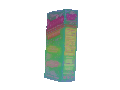

In [58]:
pc_img, img = render_embedding_image(angle_to_pose(best_angle), keypoint_coordinates, keypoint_embeddings)
colors = get_colors(observed_embeddings, proj_V)
rgba = jnp.array(b.get_rgb_image(colors * 255.0))
rgba = rgba.at[pc_img[:,:,2] > intrinsics.far - 0.01, :3].set(255.0)
b.get_rgb_image(rgba)

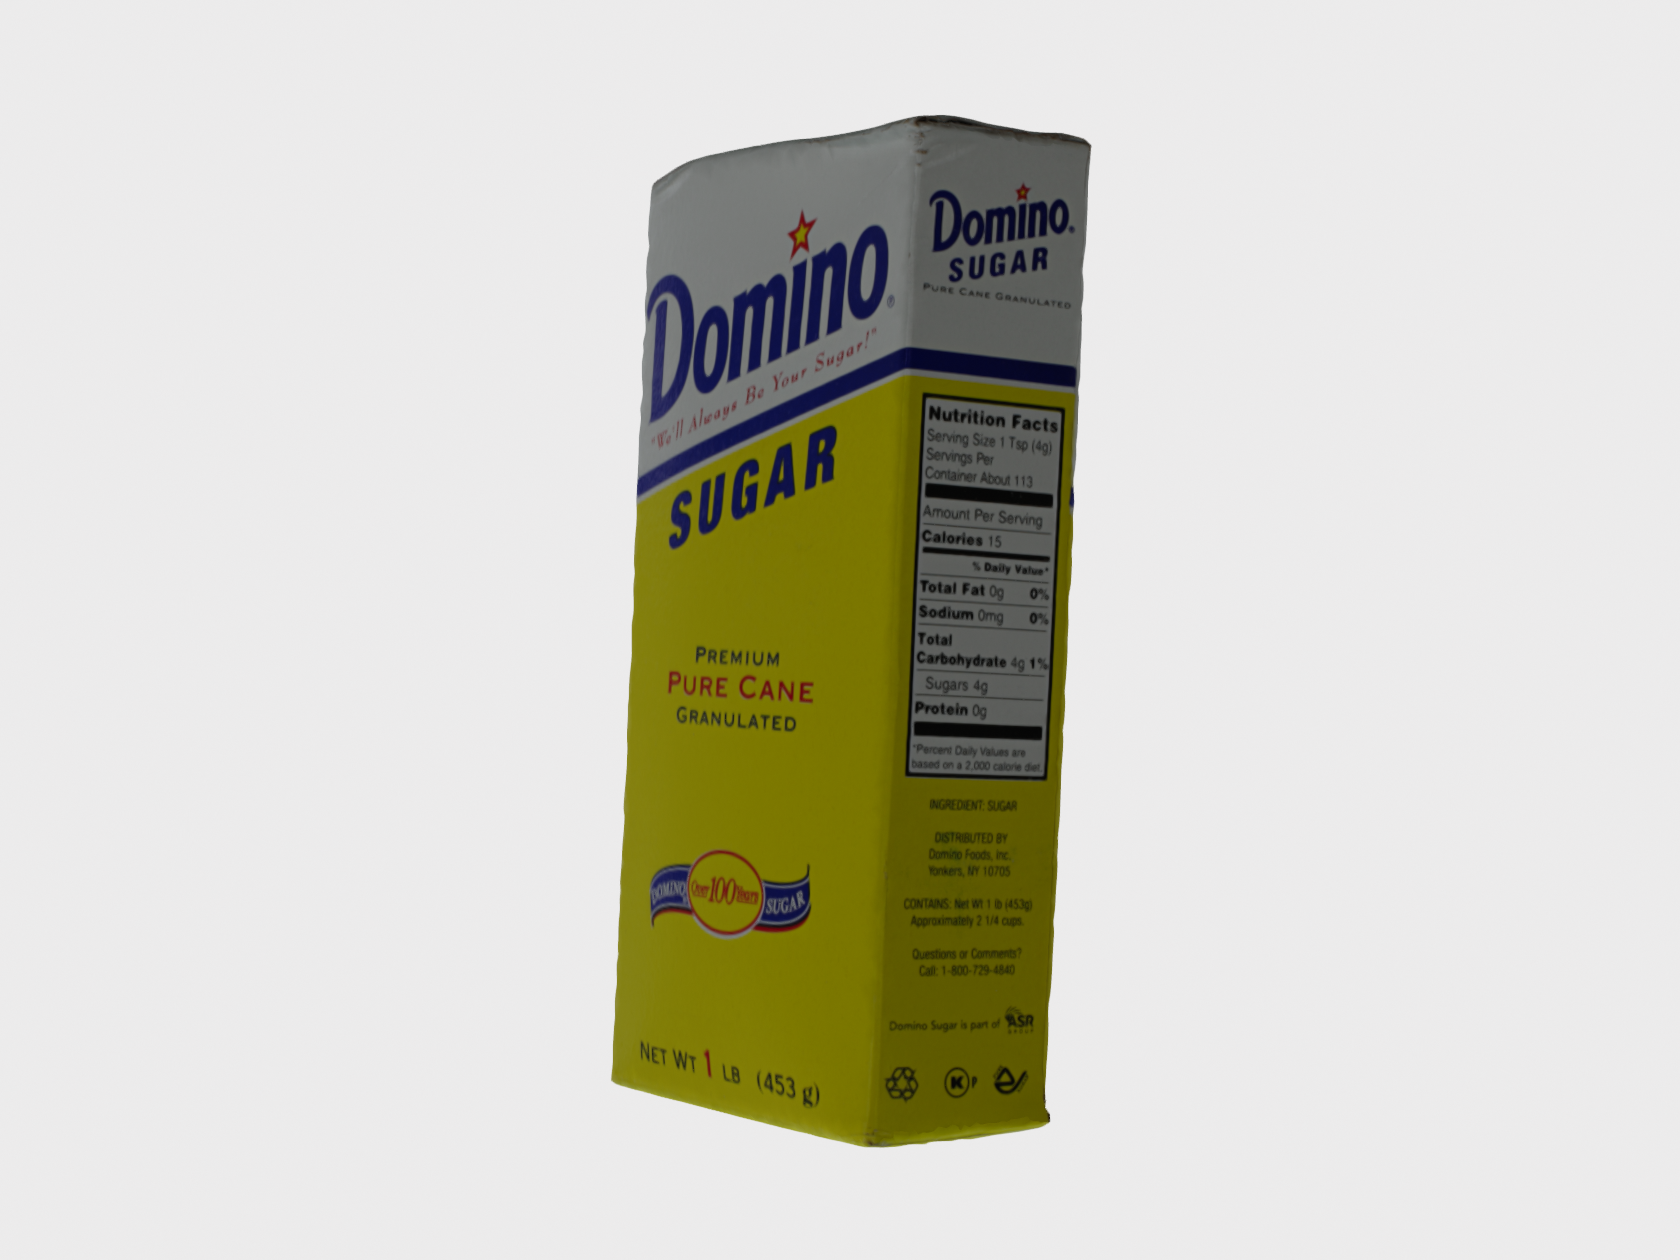

In [46]:
b.get_rgb_image(test_rgbd.rgb)

In [59]:
import meshcat.geometry as g

proj_V = get_pca(keypoint_embeddings)
colors = get_colors(keypoint_embeddings, proj_V)
b.clear()
obj = g.PointCloud(np.transpose(keypoint_coordinates)*30.0, np.transpose(colors), size=0.1)
b.meshcatviz.VISUALIZER["2"].set_object(obj)

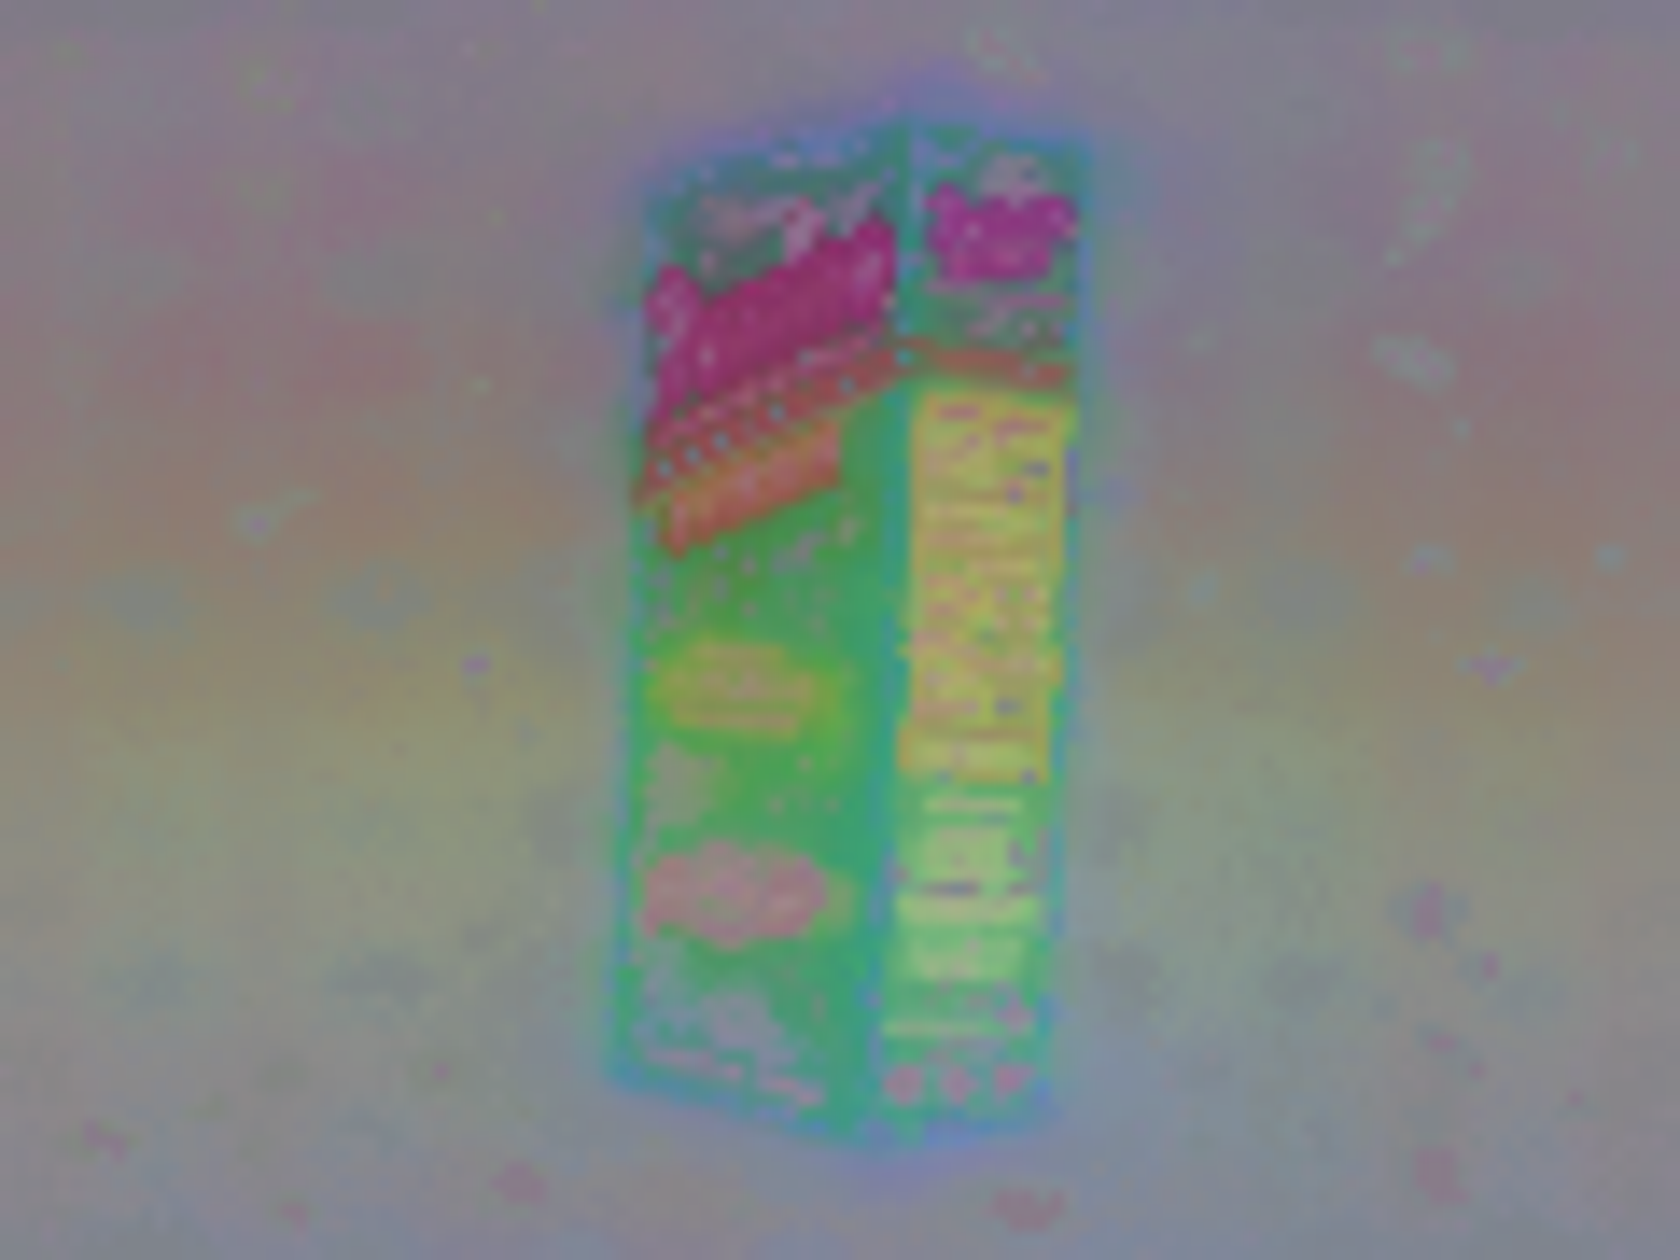

In [60]:
colors = get_colors(observed_embeddings, proj_V)
b.scale_image(b.get_rgb_image(colors * 255.0),14.0)

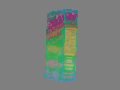

In [50]:
_,rendered_embedding_image = render_embedding_image(best_pose,keypoint_coordinates, keypoint_embeddings)
colors = get_colors(rendered_embedding_image, proj_V)
b.get_rgb_image(colors * 255.0)

In [52]:
rendered_embedding_image @ proj_V

Array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

In [34]:
colors

Array([[[0.6616304 , 0.5605376 , 0.58154356],
        [0.6616304 , 0.5605376 , 0.58154356],
        [0.6616304 , 0.5605376 , 0.58154356],
        ...,
        [0.6616304 , 0.5605376 , 0.58154356],
        [0.6616304 , 0.5605376 , 0.58154356],
        [0.6616304 , 0.5605376 , 0.58154356]],

       [[0.6616304 , 0.5605376 , 0.58154356],
        [0.6616304 , 0.5605376 , 0.58154356],
        [0.6616304 , 0.5605376 , 0.58154356],
        ...,
        [0.6616304 , 0.5605376 , 0.58154356],
        [0.6616304 , 0.5605376 , 0.58154356],
        [0.6616304 , 0.5605376 , 0.58154356]],

       [[0.6616304 , 0.5605376 , 0.58154356],
        [0.6616304 , 0.5605376 , 0.58154356],
        [0.6616304 , 0.5605376 , 0.58154356],
        ...,
        [0.6616304 , 0.5605376 , 0.58154356],
        [0.6616304 , 0.5605376 , 0.58154356],
        [0.6616304 , 0.5605376 , 0.58154356]],

       ...,

       [[0.6616304 , 0.5605376 , 0.58154356],
        [0.6616304 , 0.5605376 , 0.58154356],
        [0.6616304 , 0

In [69]:
b.setup_renderer(test_rgbd.intrinsics)
b.RENDERER.add_mesh_from_file(mesh_filename, scaling_factor=SCALING_FACTOR)
point_cloud_img = b.RENDERER.render_single_object(best_pose, jnp.int32(0))[:,:,:3]

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (1696, 1280, 1024)


0.55225414 0.6281761


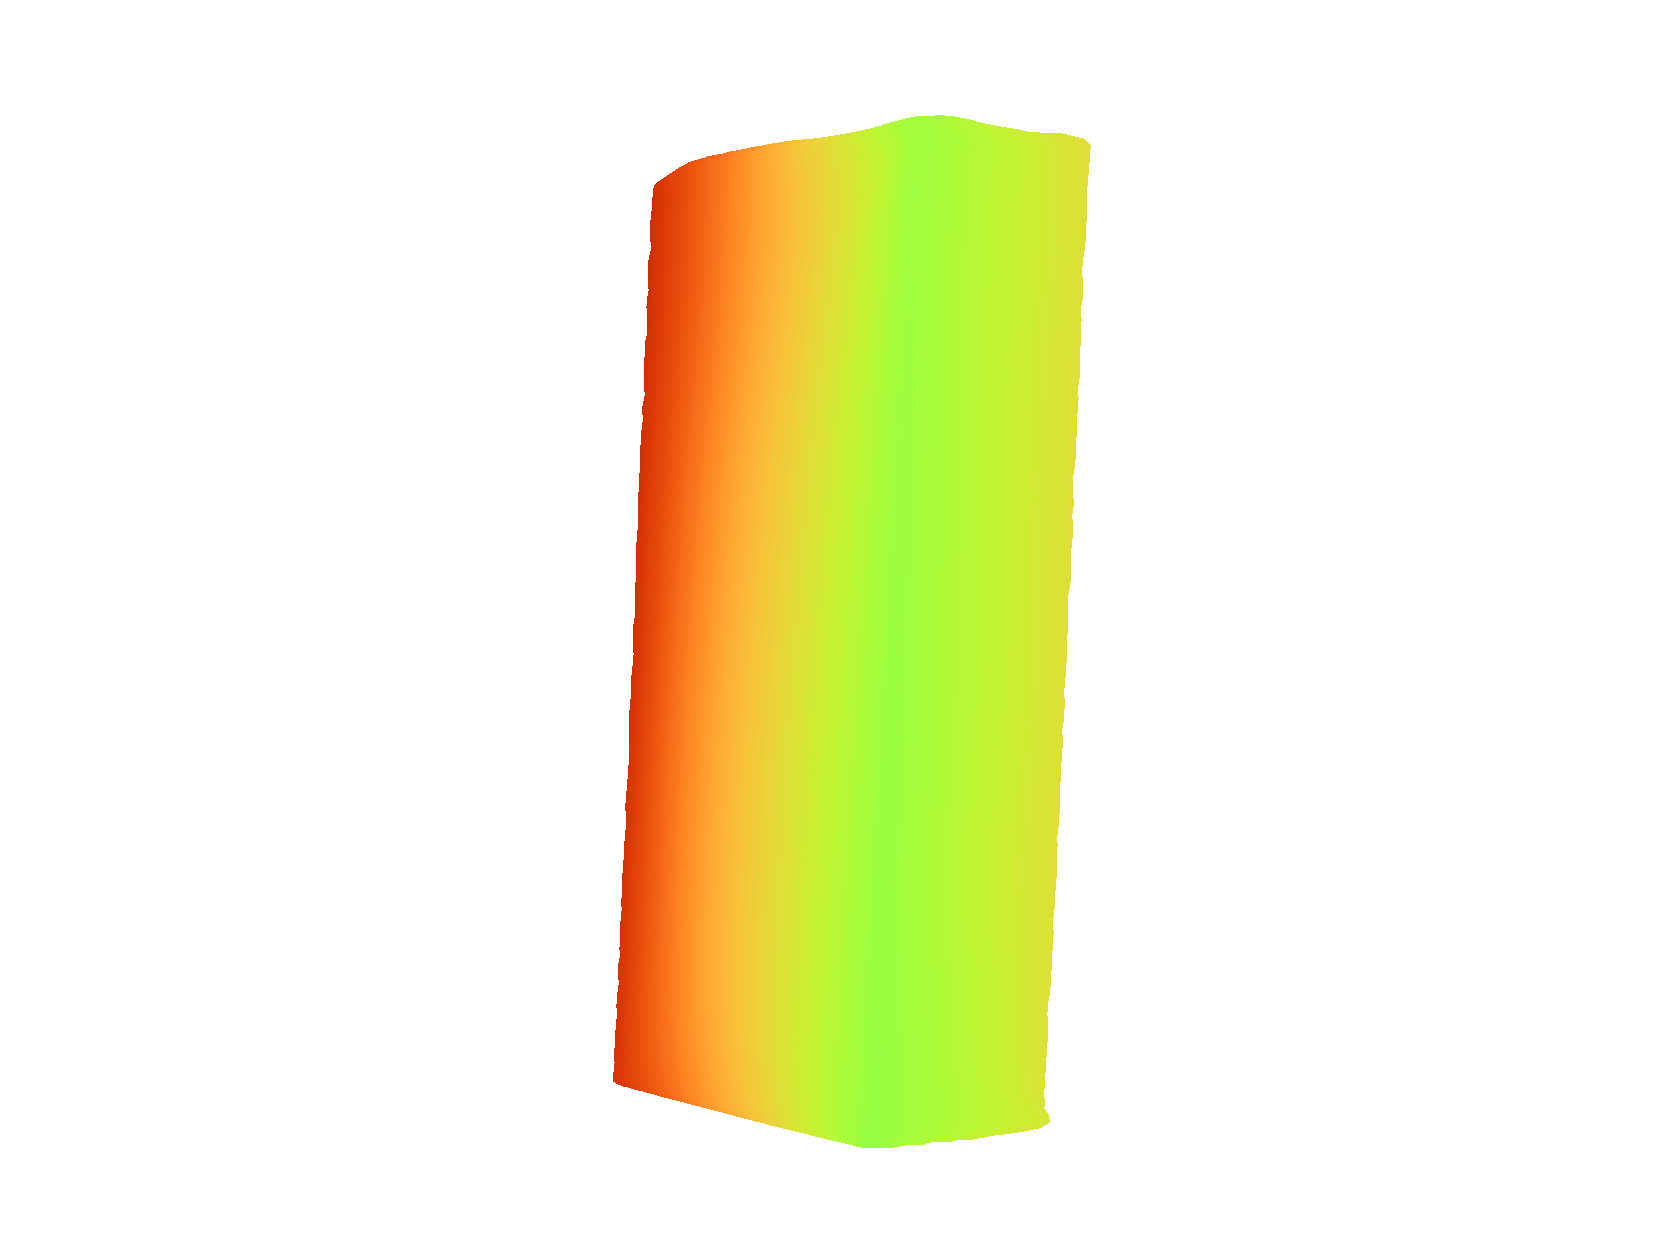

In [74]:
mask = (test_rgbd.intrinsics.near < point_cloud_img[:,:,2]) * (point_cloud_img[:,:,2] < test_rgbd.intrinsics.far)
print(point_cloud_img[:,:,2][mask].min(), point_cloud_img[:,:,2][mask].max())
b.get_depth_image(1.0 * mask)
img = jnp.array(b.get_depth_image(point_cloud_img[:,:,2], min=0.46, max=0.65))
img = img.at[jnp.invert(mask) , :3].set(255.0)
b.get_rgb_image(img)

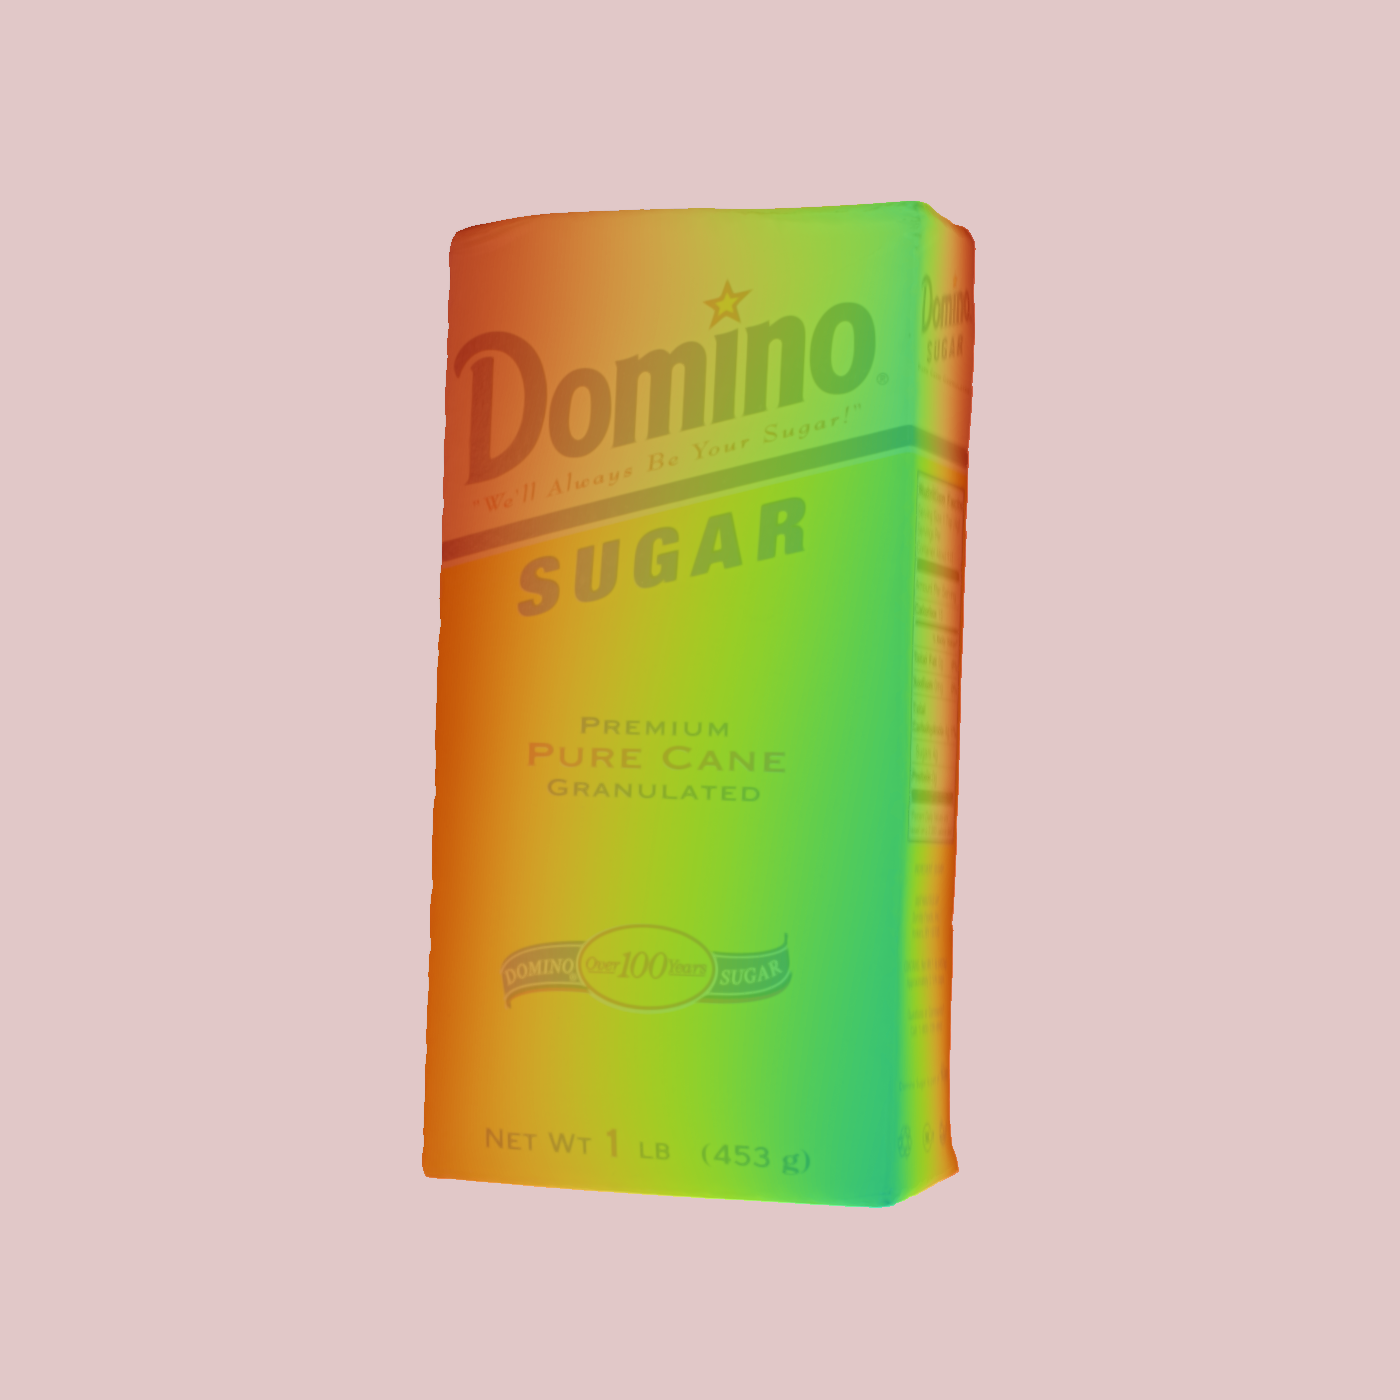

In [59]:
b.overlay_image(b.get_rgb_image(test_rgbd.rgb), b.get_rgb_image(img), 0.7)

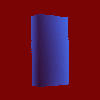

In [224]:
x

In [211]:
point_cloud_img[:,:,2]

Array([[6., 6., 6., ..., 6., 6., 6.],
       [6., 6., 6., ..., 6., 6., 6.],
       [6., 6., 6., ..., 6., 6., 6.],
       ...,
       [6., 6., 6., ..., 6., 6., 6.],
       [6., 6., 6., ..., 6., 6., 6.],
       [6., 6., 6., ..., 6., 6., 6.]], dtype=float32)

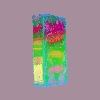

In [188]:
pose = best_pose
point_cloud_img = b.RENDERER.render_single_object(pose, jnp.int32(0))[:,:,:3]
point_cloud_img_in_object_frame = b.t3d.apply_transform(point_cloud_img, b.t3d.inverse_pose(pose))

distances_to_keypoints = (
    jnp.linalg.norm(point_cloud_img_in_object_frame[:, :,None,...] - keypoint_coordinates[None, None,:,...],
    axis=-1
))
index_of_nearest_keypoint = distances_to_keypoints.argmin(2)
distance_to_nearest_keypoints = distances_to_keypoints.min(2)

DISTANCE_THRESHOLD = 0.2
valid_match_mask = (distance_to_nearest_keypoints < DISTANCE_THRESHOLD)[...,None]
selected_keypoints = keypoint_coordinates[index_of_nearest_keypoint]
rendered_embeddings_image = keypoint_embeddings[index_of_nearest_keypoint] * valid_match_mask

colors = get_colors(rendered_embeddings_image, proj_V)
b.get_rgb_image(colors * 255.0)